In [ ]:
import torch
import torch.nn as nn
from torchview import draw_graph
from einops import rearrange
from tqdm import tqdm
import torch.nn.functional  as Fn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from io import BytesIO
from IPython.display import Image as IPyImage, display
from PIL import Image
import matplotlib.pyplot as plt
import os
from piq import ssim

import wandb
wandb.login()

In [ ]:
wandb.init(
    project="VQVAE-Transformer",  
    name="experiment-1",    
    id="fe9htihr",  # Same ID as before
    resume="allow",
    config={                       
        "epochs": 100,
        "batch_size": 16,
    }
)

# wandb.init(
#     project="experiment-1",
#     id="VQVAE-Transformer",  # Same ID as before
#     resume="allow"  # or "must"
# )

Implementation
https://www.youtube.com/watch?v=1mi2MSvigcc&t=18s

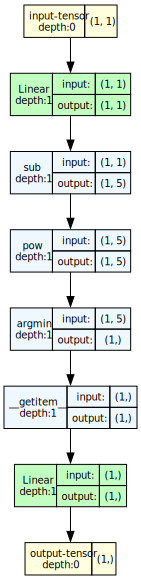

In [250]:
class VQVAEQuantizeWithoutDerivative(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(1, 1)
        self.codebook = nn.Parameter(torch.tensor([-5., -9., 0., 6., 9.]))
        self.decoder = nn.Linear(1, 1)

    def forward(self, x):
        encoder_out = self.encoder(x)
        l2_difference = (encoder_out - self.codebook) ** 2
        nearest_index = torch.argmin(l2_difference, dim = -1)
        # print(nearest_index)
        decoder_input = self.codebook[nearest_index]
        # print(decoder_input)
        decoder_out = self.decoder(decoder_input)
        return decoder_out

q = VQVAEQuantizeWithoutDerivative()
test = torch.ones(1).unsqueeze(0)
out = q(test)
# print(out)
out.backward()
model_graph = draw_graph(q, input_size = (1, 1))
model_graph.visual_graph

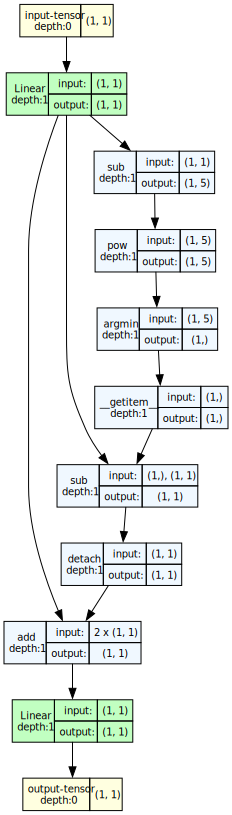

In [251]:
class VQVAEQuantizeWithDerivative(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(1, 1)
        self.codebook = nn.Parameter(torch.tensor([-5., -9., 0., 6., 9.]))
        self.decoder = nn.Linear(1, 1)

    def forward(self, x):
        encoder_out = self.encoder(x)
        l2_difference = (encoder_out - self.codebook) ** 2
        nearest_index = torch.argmin(l2_difference, dim = -1)
        # print(nearest_index)
        decoder_input = self.codebook[nearest_index]
        # print(decoder_input)
        decoder_input = encoder_out + (decoder_input - encoder_out).detach()
        decoder_out = self.decoder(decoder_input)
        return decoder_out

q = VQVAEQuantizeWithDerivative()
test = torch.ones(1).unsqueeze(0)
out = q(test)
# print(out)
out.backward()
model_graph = draw_graph(q, input_size = (1, 1))
model_graph.visual_graph

In [252]:
class VectorQuantizeImage(nn.Module):
    def __init__(self, codeBookDim = 64, embeddingDim = 32, decay = 0.99, eps = 1e-5):
        super().__init__()

        self.codeBookDim = codeBookDim
        self.embeddingDim = embeddingDim
        self.decay = decay
        self.eps = eps
        self.dead_codeBook_threshold = codeBookDim * 0.6

        self.codebook = nn.Embedding(codeBookDim, embeddingDim)
        nn.init.xavier_uniform_(self.codebook.weight.data)

        self.register_buffer('ema_Count', torch.zeros(codeBookDim))
        self.register_buffer('ema_Weight', self.codebook.weight.data.clone())

    def forward(self, x):
        x_reshaped = x.view(-1, self.embeddingDim)

        distance = (torch.sum(x_reshaped**2, dim=1, keepdim=True) 
                    + torch.sum(self.codebook.weight**2, dim=1)
                    - 2 * torch.matmul(x_reshaped, self.codebook.weight.t()))
        
        encoding_indices = torch.argmin(distance, dim=1) 
        encodings = Fn.one_hot(encoding_indices, self.codeBookDim).type(x_reshaped.dtype)
        quantized = torch.matmul(encodings, self.codebook.weight)

        if self.training:
            self.ema_Count = self.decay * self.ema_Count + (1 - self.decay) * torch.sum(encodings, 0)
            
            x_reshaped_sum = torch.matmul(encodings.t(), x_reshaped.detach())
            self.ema_Weight = self.decay * self.ema_Weight + (1 - self.decay) * x_reshaped_sum
            
            n = torch.clamp(self.ema_Count, min=self.eps)
            updated_embeddings = self.ema_Weight / n.unsqueeze(1)
            self.codebook.weight.data.copy_(updated_embeddings)

        
        avg_probs = torch.mean(encodings, dim=0)
        log_encoding_sum = -torch.sum(avg_probs * torch.log(avg_probs + 1e-10))
        perplexity = torch.exp(log_encoding_sum)

        entropy = log_encoding_sum
        normalized_entropy = entropy / torch.log(torch.tensor(self.codeBookDim, device=x.device))
        diversity_loss = 1.0 - normalized_entropy

        return quantized, encoding_indices, perplexity, diversity_loss
        
        
vq = VectorQuantizeImage(codeBookDim=64,embeddingDim=32)
rand = torch.randn(1024,32)
vq(rand)

(tensor([[ 0.0828, -0.1440, -0.0997,  ..., -0.2408,  0.1363, -0.0906],
         [ 0.0561, -0.1480,  0.0800,  ..., -0.1872,  0.1779, -0.1716],
         [ 0.1312, -0.0175, -0.1073,  ..., -0.1056, -0.0428,  0.1245],
         ...,
         [ 0.2165,  0.0827,  0.2233,  ...,  0.2355, -0.1114, -0.1829],
         [ 0.0478, -0.1575, -0.2166,  ..., -0.1311,  0.2207,  0.1691],
         [ 0.0884, -0.2036,  0.0763,  ..., -0.1666,  0.0579, -0.1919]],
        grad_fn=<MmBackward0>),
 tensor([ 7, 20, 16,  ..., 52, 40,  8]),
 tensor(60.5774),
 tensor(0.0132))

In [253]:
class VecQVAE(nn.Module):
    def __init__(self, inChannels = 1, hiddenDim = 32, codeBookdim = 128, embedDim = 128):
        super().__init__()
        self.inChannels = inChannels
        self.hiddenDim = hiddenDim
        self.codeBookdim = codeBookdim
        self.embedDim = embedDim

        self.encoder = nn.Sequential(
            nn.Conv2d(inChannels, hiddenDim, 4, 2, 1), 
            nn.BatchNorm2d(hiddenDim),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(hiddenDim, hiddenDim, 3, 1, 1),
            nn.BatchNorm2d(hiddenDim),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(hiddenDim, 2 * hiddenDim, 4, 2, 1),
            nn.BatchNorm2d(2 * hiddenDim),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(2 * hiddenDim, 2 * hiddenDim, 3, 1, 1),
            nn.BatchNorm2d(2 * hiddenDim),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(2 * hiddenDim, embedDim, 1),
        )

        self.vector_quantize = VectorQuantizeImage(codeBookDim=codeBookdim,embeddingDim=embedDim)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embedDim, 2 * hiddenDim, 4, 2, 1),
            nn.BatchNorm2d(2 * hiddenDim),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(2 * hiddenDim, 2 * hiddenDim, 3, 1, 1),
            nn.BatchNorm2d(2 * hiddenDim),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(2 * hiddenDim, hiddenDim, 4, 2, 1),
            nn.BatchNorm2d(hiddenDim),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(hiddenDim, hiddenDim, 3, 1, 1),
            nn.BatchNorm2d(hiddenDim),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(hiddenDim, inChannels, 1),
            nn.Sigmoid()
        )

    def encodeImage(self, x, noise_std = 0.15):
        if self.training:
            encodedOut = self.encoder(x)
            encodedOut = encodedOut + torch.randn_like(encodedOut) * noise_std
        else:
            encodedOut = self.encoder(x)

        return encodedOut

    def decodeImage(self, quantized_vector):
        decodedOut = self.decoder(quantized_vector)
        return decodedOut

    def forward(self, x):
        batch_size, inChannels, height, width = x.shape
        encodedOut = self.encodeImage(x)
        batch_size, encoded_channel, encoded_height, encoded_width = encodedOut.shape
        
        # print(f"Encoded Shape: {encodedOut.shape}")

        
        vectorize_input = rearrange(encodedOut, 'b c h w -> (b h w) c')
        quantized_vectors, encoding_indices, perplexity, diversity_loss  = self.vector_quantize(vectorize_input)
        codebook_loss = Fn.mse_loss(vectorize_input.detach(), quantized_vectors)
        commitment_loss = Fn.mse_loss(vectorize_input, quantized_vectors.detach())

        quantized_vectors = vectorize_input + (quantized_vectors - vectorize_input).detach()
        # print(f"CodeBook Loss: {codebook_loss} , Commitment Loss: {commitment_loss}")
        # print(f"Quantized SHape: {quantized_vectors.shape}")

        decoder_input = rearrange(quantized_vectors, '(b h w) d -> b d h w', d = encoded_channel, h = encoded_height, w = encoded_width)
        # print(f"Decoded Input SHape: {decoder_input.shape}")
        decodedOut = self.decodeImage(decoder_input)

        # print(f"Decoded SHape: {decodedOut.shape}")
        
        return decoder_input, decodedOut, codebook_loss, commitment_loss, encoding_indices, perplexity, diversity_loss

VQ = VecQVAE(inChannels = 1, hiddenDim = 256, codeBookdim = 128, embedDim = 64)
test = torch.randn(32, 1, 64, 64)
quantized_latents, decoderOut, codebook_loss, commitment_loss, encoding_indices, perplexity, diversity_loss = VQ(test)
quantized_latents.shape, decoderOut.shape, codebook_loss, commitment_loss, encoding_indices.shape, perplexity, diversity_loss

(torch.Size([32, 64, 16, 16]),
 torch.Size([32, 1, 64, 64]),
 tensor(0.1595, grad_fn=<MseLossBackward0>),
 tensor(0.1595, grad_fn=<MseLossBackward0>),
 torch.Size([8192]),
 tensor(45.0726),
 tensor(0.2151))

In [254]:
data = np.load("data/MovingMNIST/mnist_test_seq.npy")
print(data.shape)
data = np.transpose(data, (1, 0, 2, 3))
data = torch.from_numpy(data)
data = data.unsqueeze(2)
print(data.shape)
flattened_frame_dataset = data.reshape(-1, 1, 64, 64)
print(flattened_frame_dataset.shape)
flattened_frame_dataset[0].shape

(20, 10000, 64, 64)
torch.Size([10000, 20, 1, 64, 64])
torch.Size([200000, 1, 64, 64])


torch.Size([1, 64, 64])

In [255]:
flattened_frame_dataset = data.reshape(-1, 1, 64, 64)
print(flattened_frame_dataset.shape)
flattened_frame_dataset[0].shape

torch.Size([200000, 1, 64, 64])


torch.Size([1, 64, 64])

In [256]:
class FrameDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data
        self.data = self.data/255.0
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        return self.data[index], self.data[index]
    

test = torch.randn(1000, 1, 64, 64)
out = FrameDataset(test)
print(out.__len__())
x, y = out.__getitem__(0)
x.shape, y.shape


1000


(torch.Size([1, 64, 64]), torch.Size([1, 64, 64]))

In [257]:
codeBookdim = 128
embedDim = 64
hiddenDim = 256
inChannels = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torchDataset = FrameDataset(flattened_frame_dataset)
dataloader = DataLoader(torchDataset, batch_size=64, shuffle = True)
modelA = VecQVAE(inChannels = inChannels, hiddenDim = hiddenDim, codeBookdim = codeBookdim, embedDim = embedDim).to(device)
lossFn = nn.MSELoss()
optimizerA = torch.optim.Adam([
                    {'params': modelA.encoder.parameters(), 'lr': 2e-4},
                    {'params': modelA.decoder.parameters(), 'lr': 2e-4},
                    {'params': modelA.vector_quantize.parameters(), 'lr': 1e-4}
                ], weight_decay=1e-5)
schedulerA = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizerA, T_0=10, T_mult=2, eta_min=1e-6
            )

epochs = 1000

In [258]:
modelValA = torch.load("./model/VQVAE/vqvae.pt", map_location=torch.device('cpu'))
modelA.load_state_dict(modelValA)

for each_epoch in range(epochs):
    modelA.train()
    reconstruct_loss = 0.0
    codeb_loss = 0.0
    commit_loss = 0.0
    vqvaeloss = 0.0
    diverse_loss = 0.0
    ssim_loss = 0.0
    
    loop = tqdm(dataloader, f"{each_epoch}/{epochs}")
    perplexities = []

    for X, Y in loop:
        X = X.to(device)
        Y = Y.to(device)
        # print(X.shape, Y.shape)
    #     break
    # break
        
        quantized_latents, decoderOut, codebook_loss, commitment_loss, encoding_indices, perplexity, diversity_loss = modelA(X)

        ssim_score = ssim(Y, decoderOut, data_range=1.0)
        ssim_loss = 1.0 - ssim_score

        reconstruction_loss = torch.mean((Y - decoderOut)**2)
        
        loss = reconstruction_loss + codebook_loss + 0.2 * commitment_loss + 0.1 * diversity_loss + 0.1 * ssim_loss
        vqvaeloss += loss.item()

        
        reconstruct_loss += reconstruction_loss.item()
        diverse_loss += diversity_loss.item()
        codeb_loss += codebook_loss.item()
        commit_loss += commitment_loss.item()
        ssim_loss += ssim_loss.item()
        perplexities.append(perplexity)
        
        
        optimizerA.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(modelA.parameters(), max_norm=1.0)
        optimizerA.step()
        loop.set_postfix({"TotalL": f"{vqvaeloss}", "ReconsL": f"{reconstruct_loss}", "CodeL":f"{codeb_loss}",
                          "CommitL":f"{commitment_loss}", "Perplexity":f"{perplexity}", "Diversity Loss":f"{diverse_loss}", "SSIM Loss":f"{ssim_loss}"})
    #     break
    # break

    average_perplexity = sum(perplexities)/len(perplexities)
    vqvaeloss /= len(dataloader)   
    reconstruct_loss /= len(dataloader)   
    codeb_loss /= len(dataloader)   
    commit_loss /= len(dataloader)   
    diverse_loss /= len(dataloader)
    torch.save(modelA.state_dict(), "./model/VQVAE/vqvae.pt")
    wandb.log({
        "Epoch": each_epoch,
        "VQVAE LR": optimizerA.param_groups[0]['lr'],
        "VQVAE Loss": vqvaeloss,
        "Reconstruction Loss": reconstruct_loss,
        "Codebook Loss": codeb_loss,
        "Commitment Loss": commit_loss,
        "Diversity Loss": diverse_loss,
        "Perplexity": average_perplexity,
        "SSIM Loss":ssim_loss,
    })
    schedulerA.step()
 

0/1000:   0%|          | 0/3125 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [305]:
modelValA = torch.load("./model/VQVAE/vqvae-5.pt", map_location=torch.device('cpu'))
modelA.load_state_dict(modelValA)

<All keys matched successfully>

In [306]:
def testImages(imagepath, model):
    img = Image.open(imagepath)
    img = img.convert("L")
    img = img.resize((64, 64))
    img_array = np.array(img)
    img_array = np.array(img).astype(np.float32)
    
    tensor = torch.from_numpy(img_array).unsqueeze(0).unsqueeze(0)

    out_image, _, _, _, _, _, _ = model(tensor/255.0)
    out_image = model.decodeImage(out_image)
    out_image = out_image.squeeze()
    out_image = (out_image * 255).byte().cpu().numpy()

    fig, axs = plt.subplots(1, 2)

    axs[0].imshow(img_array, cmap='gray')
    axs[0].axis('off')
    axs[0].set_title("Actual Image", fontsize=8)

    # Generated image
    axs[1].imshow(out_image, cmap='gray')
    axs[1].axis('off')
    axs[1].set_title("Generated Image", fontsize=8)

    plt.tight_layout()
    plt.show()


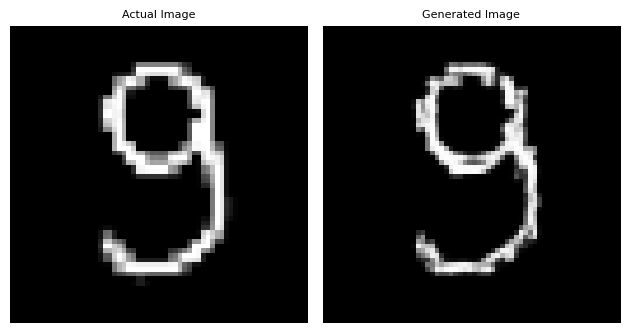

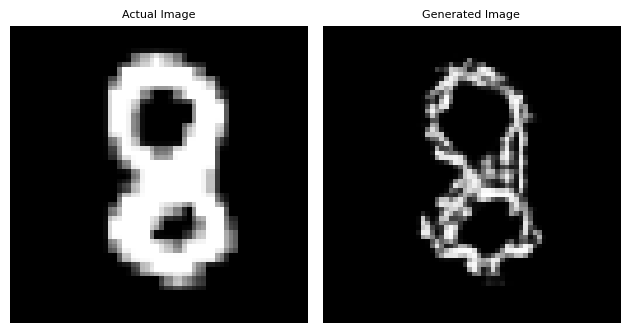

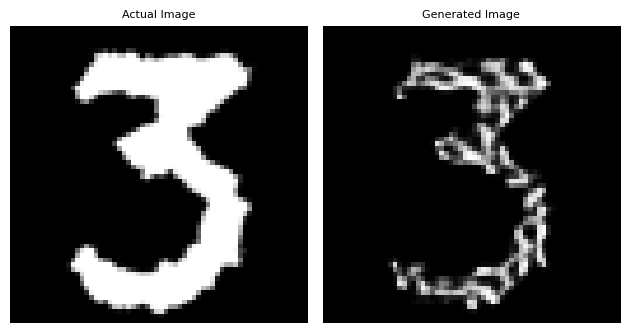

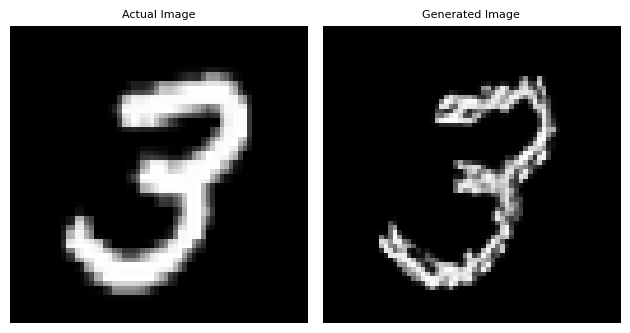

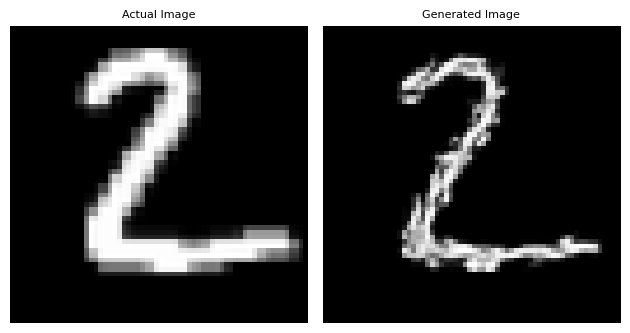

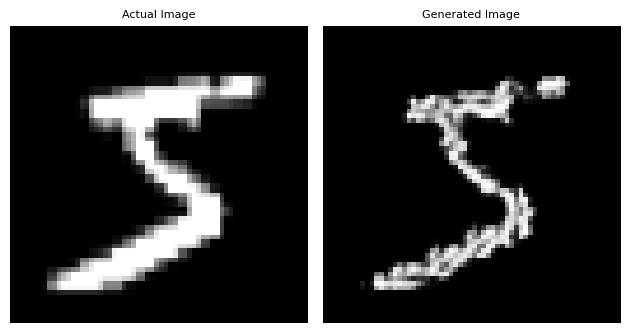

In [307]:
for i in os.listdir("data/testImages"):
    # print(i)
    testImages("data/testImages/"+i, modelA)

In [308]:
modelValA = torch.load("./model/VQVAE/vqvae-5.pt", map_location=torch.device('cpu'))
modelA.load_state_dict(modelValA)

<All keys matched successfully>

In [322]:
data = np.load("data/MovingMNIST/mnist_test_seq.npy")
print(data.shape)
data = np.transpose(data, (1, 0, 2, 3))
data = torch.from_numpy(data).to(dtype=torch.float32)

trainData, validationData = data[:9990], data[9990:]
trainData.shape, validationData.shape

(20, 10000, 64, 64)


(torch.Size([9990, 20, 64, 64]), torch.Size([10, 20, 64, 64]))

In [ ]:
encodeA = modelA.encodeImage(data[10, 0].unsqueeze(0).unsqueeze(0)/255.0)
encodeA.shape

decodeA = modelA.decodeImage(encodeA)
decodeA.shape

torch.Size([1, 1, 64, 64])

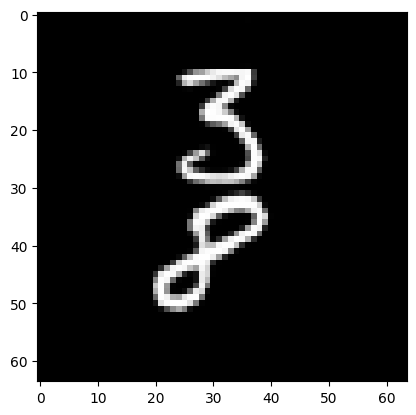

In [320]:
out_image = decodeA.squeeze()
out_image = (out_image * 255).byte().cpu().numpy()
out_image.shape

# plt.plot(out_image)
plt.imshow(out_image, cmap='gray')

In [ ]:
class Transformer(nn.Module):
    def __init__(self, vocab_size=512, seq_length = 10, embed_dim=256, num_heads=4, feed_forward_dim=512):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.seq_length = seq_length
        
        self.positional_encoding = nn.Parameter(torch.randn(1, seq_length, embed_dim, embed_dim))
        
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=feed_forward_dim,
            dropout=0.1,
            batch_first=True 
        )
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=6)
        
        self.output_layer = nn.Linear(embed_dim, 1)

    def forward(self, x):
        
        batch, features = x.shape
        x = rearrange(x, 'b (s e) -> b s e', e = self.embed_dim, s = self.seq_length)
        x = self.embedding(x)
        
        x = x + self.positional_encoding
        x = rearrange(x, 'b s e d -> b (s e) d', e = self.embed_dim, s = self.seq_length)
        x = self.encoder(x)
        x = self.output_layer(x)
        
        x = rearrange(x, 'b s e -> b (s e)')
        
        return x

 
tr = Transformer()
test = torch.randint(0, 10, (2, 2560))

out = tr(test)
print(out.shape)

torch.Size([2, 2560])


In [7]:
class MakeVideoDataset(Dataset):
    def __init__(self, video, input_length=10, output_length=10):
        super().__init__()
        self.video = video
        self.input_length = input_length
        self.output_length = output_length
        self.batch_size, self.seq_len, _, _, _ = video.shape

        self.samples_per_video = self.seq_len - input_length - output_length + 1
        self.total_samples = self.batch_size * self.samples_per_video

    def __len__(self):
        return self.total_samples

    def __getitem__(self, idx):
        batch_idx = idx // self.samples_per_video
        time_idx = idx % self.samples_per_video

        input_frames = self.video[batch_idx, time_idx:time_idx + self.input_length]
        output_frames = self.video[batch_idx, time_idx + self.input_length:time_idx + self.input_length + self.output_length]

        return (
            torch.tensor(input_frames, dtype=torch.float32),
            torch.tensor(output_frames, dtype=torch.float32)
        )

    
    
test = torch.randn(32, 20, 1, 4, 4)
out = MakeVideoDataset(test)
x, y = out.__getitem__(0)
x.shape, y.shape

/var/folders/y8/q2s37ndx6tg3lpzp3vp8xk_r0000gn/T/ipykernel_11585/2549432269.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(input_frames, dtype=torch.float32),
/var/folders/y8/q2s37ndx6tg3lpzp3vp8xk_r0000gn/T/ipykernel_11585/2549432269.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(output_frames, dtype=torch.float32)


(torch.Size([10, 1, 4, 4]), torch.Size([10, 1, 4, 4]))

In [8]:
data = np.load("data/MovingMNIST/mnist_test_seq.npy")
print(data.shape)
data = np.transpose(data, (1, 0, 2, 3))
data = torch.from_numpy(data)
data = data.unsqueeze(2)
data.shape

(20, 10000, 64, 64)


torch.Size([10000, 20, 1, 64, 64])

In [ ]:
device = torch.device('mps' if torch.cuda.is_available() else 'cpu')
torchDataset = MakeVideoDataset(data)
dataloader = DataLoader(torchDataset, batch_size=8, shuffle = True)

transformer_celoss =nn.CrossEntropyLoss()
modelA = Transformer().to(device)
modelB = VecQVAE().to(device)

optimizerA = optim.AdamW(modelA.parameters(), lr=5e-5)
optimizerB = optim.Adam(modelB.parameters(), lr=2e-4)
schedulerA = StepLR(optimizerA, step_size=10, gamma=0.5)  
schedulerB = StepLR(optimizerB, step_size=20, gamma=0.7)  

epochs = 100

In [ ]:
for each_epoch in range(epochs):

    loop = tqdm(dataloader, f"{each_epoch}/{epochs}")
    for datapoint in loop:
        # print(datapoint[0].shape, datapoint[1].shape)
        datapoint[0] = datapoint[0]/255.0
        datapoint[1] = datapoint[1]/255.0

        input_indices = []
        output_indices = []
        vqvaeloss = 0.0
        transformer_loss = 0.0
        totalLoss = 0.0

        for each_frame_index in range(datapoint[0].shape[1]):
            each_input_frame = datapoint[0][:, each_frame_index, ...]
            each_input_frame = each_input_frame.to(device)
            out, ez, qz, inputindex = modelB(each_input_frame)
            vqvaeloss += VecQVAELoss(each_input_frame, out, ez, qz)

            each_output_frame = datapoint[1][:, each_frame_index, ...]
            each_output_frame = each_output_frame.to(device)
            out, ez, qz, outputindex = modelB(each_output_frame)
            vqvaeloss += VecQVAELoss(each_output_frame, out, ez, qz)

            input_indices.append(inputindex)
            output_indices.append(outputindex)

        # print(vqvaeloss)
        inputCodeboobIndices = torch.cat(input_indices, dim=-1)
        outputCodeboobIndices = torch.cat(output_indices, dim=-1)
        inputCodeboobIndices = inputCodeboobIndices.to(device)
        outputCodeboobIndices = outputCodeboobIndices.to(device)

        # print(inputCodeboobIndices.shape)
        predX = modelA(inputCodeboobIndices)
        # y = modelA(outputCodeboobIndices)
        # print(predX.shape, inputCodeboobIndices.shape, outputCodeboobIndices.shape)
        
        predX = rearrange(predX, 'b (d l) -> b d l', l = 10)
        outputCodeboobIndices = rearrange(outputCodeboobIndices, 'b (d l) -> b d l', l = 10)

        loss = transformer_celoss(predX, outputCodeboobIndices.float())
        # # transformer_loss += loss.item()

        combined_loss = loss + vqvaeloss
        

        optimizerA.zero_grad()
        optimizerB.zero_grad()

        combined_loss.backward()

        optimizerA.step()
        optimizerB.step()
        loop.set_postfix({"VQVAE Loss": f"{vqvaeloss.item()}", " Transformer Loss": f"{loss.item()}", " Total Loss": f"{combined_loss.item()}"})
        
    # if each_epoch % 5 == 0:
    torch.save(modelA.state_dict(), "./model/VQVAE/transformer.pt")
    torch.save(modelB.state_dict(), "./model/VQVAE/vqvae.pt")
    wandb.log({
        "Epoch": each_epoch,
        "VQVAE Loss": vqvaeloss.item(),
        "Transformer Loss": loss.item(),
        "Total Loss": combined_loss.item(),
        "Transformer LR" : optimizerA.param_groups[0]['lr'],
        "VQVAE LR": optimizerB.param_groups[0]['lr']
    })

    schedulerA.step()
    schedulerB.step()

    

0/50:   0%|          | 0/1250 [00:00<?, ?it/s]/var/folders/y8/q2s37ndx6tg3lpzp3vp8xk_r0000gn/T/ipykernel_11585/2549432269.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(input_frames, dtype=torch.float32),
/var/folders/y8/q2s37ndx6tg3lpzp3vp8xk_r0000gn/T/ipykernel_11585/2549432269.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(output_frames, dtype=torch.float32)
0/50:   0%|          | 0/1250 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [30]:
data = np.load("data/MovingMNIST/mnist_test_seq.npy")
data = np.transpose(data, (1, 0, 2, 3))
data.shape

(10000, 20, 64, 64)

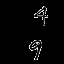

In [36]:
def visualizeData(sequence):

    frames = [Image.fromarray((frame * 255).astype(np.uint8), mode='L') for frame in sequence]

    buffer = BytesIO()
    frames[0].save(
        buffer,
        format='GIF',
        save_all=True,
        append_images=frames[1:],
        duration=100,
        loop=0
    )

    buffer.seek(0)
    display(IPyImage(data=buffer.getvalue()))

visualizeData(data[50])

In [37]:
modelValA = torch.load("model/VQVAE/transformer.pt", map_location=torch.device('mps'))
modelA.load_state_dict(modelValA)

modelValB = torch.load("model/VQVAE/vqvae.pt", map_location=torch.device('mps'))
modelB.load_state_dict(modelValB)


<All keys matched successfully>

In [ ]:
initial_frame = torch.from_numpy(data[0, 10]/255.0)

initial_frame.shape

torch.Size([64, 64])